# Motion Capture data

This dataset was taken from Reynolds, Zachs and Braver (2007) model of event segmentation. [[paper](https://www.ncbi.nlm.nih.gov/pubmed/21635310)] [[dataset/code]](https://wustl.app.box.com/s/0l0r2w2jg715cx567bli). The paper is worth reading butone of the main take away is that prediction errors are indicative of event boundaries, meaning that prediction errors are lower within an event than between them.

The data are 3d motion capture data of people moving. At each point in time, the position of the human in the recording is described by 18 points in (x, y, z) coordinate space. Motion is indicated by the updating of these points from timepoint to timepoint. There are 13 distinct events in the dataset and approximately 10 timepoints per event.

In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_file = './data/motion_data.pkl'
motion_data = pd.read_pickle(data_file)
print "Number of events:", set(motion_data.EventNumber)
print "Timepoint / event:", len(motion_data) / float(len(set(motion_data.EventNumber)))

Number of events: set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
Timepoint / event: 10.5384615385


Formally, each scence vector $s$ is a 54D vector of the 18 points in coordinate space and each event consistest of an ordered list of scene vectors. Below is a visualization of a single event in (x, y) coordinate space. Each of the events is a 3-4s long clip, sampled at 3 Hz.

For the plots on the left, you can see the trajectory of individual points in space over time. Time is represented by color, with yellow indicating early in time and red later in time (such that each of the 18 points in (x, y) space at a particular moment in time is represented with the same color). The triangle markers also denote time, getting larger across time.

The plots on the right, you can see a snapshot of an event at two moments in time. These plots should make the motion of the person more clear.

In [3]:
def plot_event(event_number):
    fig, axes = plt.subplots(1, 2, figsize=(8.3, 4), gridspec_kw={'wspace': 0.3})
    e = motion_data.loc[motion_data.EventNumber == event_number, :]
    cols = e.columns[:-1]
    e = e[cols].values

    # loop through and plot each point as it moves in time.
    cc = sns.color_palette("YlOrRd", n_colors=e.shape[0])
    for ii in range(e.shape[0]-1):
        for jj in range(18):
            axes[0].plot([e[ii, jj], e[ii+1, jj]], [e[ii, 18+jj], e[ii+1, 18+jj]],
                     color=cc[ii], marker='^', markersize=ii)
    axes[0].set_xlabel('x-coordinate')
    axes[0].set_ylabel('y-coordinate')
    
    def connect(ax, t, color, linestyle, label=None):
        # plot the connections between the points in an ordered way
        kwargs = dict(color=color, linestyle=linestyle)
        ax.plot(e[t, 0:18], e[t, 18:36], 'o', color=color, label=label)
        ax.plot(e[t, 0:4], e[t, 18:22], **kwargs)
        ax.plot(e[t, 4:7], e[t, 22:25], **kwargs)
        ax.plot(e[t, [0,4]], e[t, [0,22]], **kwargs)
        ax.plot(e[t, [0,7]], e[t, [18, 18+7]], **kwargs)
        ax.plot(e[t, [7,8]], e[t, [18+7, 18+8]], **kwargs)
        ax.plot(e[t, [7,12]], e[t, [18+7, 18+12]], **kwargs)
        ax.plot(e[t, [8,12]], e[t, [18+8, 18+12]], **kwargs)
        ax.plot(e[t, 8:12], e[t, (18+8):(18+12)], **kwargs)
        ax.plot(e[t, 12:16], e[t, (18+12):(18+16)], **kwargs)
        ax.plot(e[t, [1,18]], e[t, [18+1, 18+18]], **kwargs)
        ax.plot(e[t, [4,18]], e[t, [18+4, 18+18]], **kwargs)
        ax.plot(e[t, [16,17]], e[t, [18+16, 18+17]], **kwargs) 
        ax.plot(e[t, [8,16]], e[t, [18+8, 18+16]], **kwargs)
        ax.plot(e[t, [12,16]], e[t, [18+12, 18+16]], **kwargs)
        
    connect(axes[1], 4, [0.5, 0.5, 0.5], '--', label='t=4')
    connect(axes[1], 5, 'k', '-', label='t=5')
    axes[1].legend()


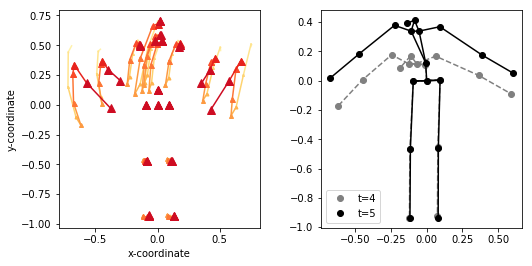

In [4]:
plot_event(1)

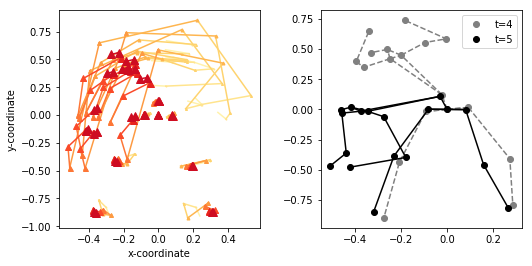

In [5]:
plot_event(8)

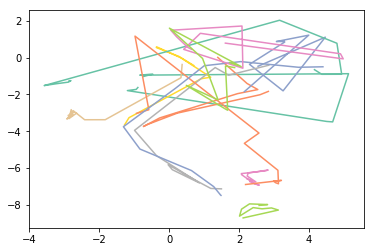

In [6]:
# plot a 2-D representation of the motion dynamics through space

from sklearn.manifold import TSNE
cols = motion_data.columns[:-1]
X = motion_data.loc[:, cols].values
tsne = TSNE(n_components=2, init='random', random_state=0, perplexity=50)
X_embedded = tsne.fit_transform(X)
e = motion_data.loc[:, motion_data.columns[-1]].values
cc = sns.color_palette('Set2', n_colors=len(set(e)))
for e0 in set(e):
    plt.plot(X_embedded[e == e0, 0], X_embedded[e == e0, 1], color=cc[e0])

# SEM Model
We can use these events generatively to create set of training data to evaluate the SEM model. To do so, we sample a random list of events and concetanate their scene vectors into a single vector:

$X = [s_1, s_2, ... , s_n]$

and create a corresponding vector of the event identities

$y = [e_i, e_i, ..., e_j]$

We can the train the SEM model to predict $X_{t+1}|X_{1:t}$. We'll evaluate the model by plotting how well it predicts the event labels, using the adjusted [Rand Index](https://en.wikipedia.org/wiki/Rand_index) as our clustering measure. Our choice of data is stochastic, as is the initialization of the model, so this will vary every time we run it.

*N.B.* The SEM is trained solely on it's ability to predict the next vector in the time series across all events $\Pr(X_t|X_{1:t-1}, \theta)$, where $\theta$ is the set of all parameters. The model is not provided with any event labels or an objective function that implicitly uses them. Thus, its segmentation is fully unsupervised (though the problem of choosing $\theta$ to maximize the Rand Index can be thought of as a supervised optimization problem).

In [7]:
import numpy as np
np.random.seed(2)
from opt.utils import generate_random_events
X_train, y_train = generate_random_events(20, data_file=data_file)

Using TensorFlow backend.


TensorFlow Version: 1.9.0
Keras      Version: 2.2.0


It is important to note that SEM is highly sensitive to the likelihood noise $\beta$:

$$\mathcal{L}(X_t|e, \theta) = \mathcal{N}\left(X_t; f(X_{1:t-1}, e, \theta), \beta\text{I}\right )$$

where $beta$ is a vector. For each event model, $\beta$ is estimated online using a MAP estimator. This allows us to use a prior over the variance and makes segmentation more stable. Generally, we'll set the prior over $\beta$ such that the prior variance is a slight overestimation of the variance of all of the vectors in the data set. This allows each new data point in a new cluster to not be very suprising, helping with the problem of rapidly switching events after an event type.

Prior variance (mode): 0.0166666666667
Median Feature variance: 0.016253005143


/anaconda3/envs/sem/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/envs/sem/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/sem/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


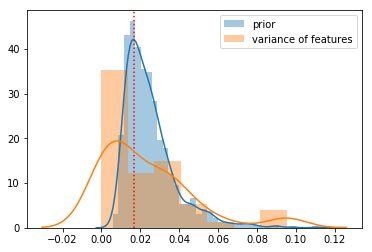

In [8]:
from models import SEM, GRUEvent
scale0 = 5.0
df0 = 0.4

import pandas as pd
from scipy.stats import chi2

# plot the prior of the variance vs an empirical estimate
df0 = 10
scale0 = 0.02

from sklearn.preprocessing import scale

sns.distplot(pd.Series([(df0*scale0)/chi2.rvs(df0) for _ in range(1000)]), label='prior')

mode = df0 * scale0 / (df0 + 2)
print("Prior variance (mode): {}".format(mode))
ylim = plt.gca().get_ylim()
plt.plot([mode, mode], ylim, 'r:')
plt.ylim(ylim)

sns.distplot(np.var(X_train, axis=0), label='variance of features')
print("Median Feature variance: {}".format(np.median(np.var(X_train, axis=0))))
plt.legend()

# X_list[-1]

Run SEM:   0%|          | 0/213 [00:00<?, ?it/s]

lambda = 100.0
alpha = 1000.0


Run SEM: 100%|██████████| 213/213 [00:23<00:00,  9.08it/s]


Adjusted Rand Index: 0.3343591504300804


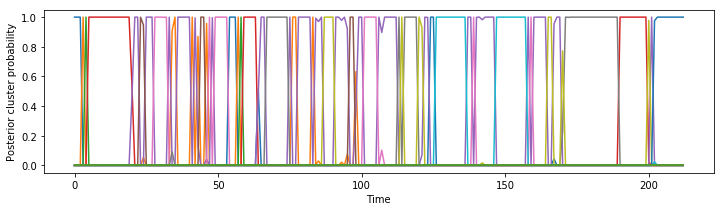

In [11]:
import tensorflow as tf
from sklearn.metrics import adjusted_rand_score

# set the parameters for the models
_, D = X_train.shape

t_horizon = 2 # time horizon to consider


lmda = 100.
alfa = 1000.0

f_class=GRUEvent
f_opts=dict(var_scale0=scale0, var_df0=df0, dropout=0.5)


Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa

sem = SEM(**Omega)
sem.run(X_train)

# get the MAP event models
y_hat = sem.results.e_hat

r = adjusted_rand_score(y_train, y_hat)

print "Adjusted Rand Index:", r
plt.figure(figsize=(12, 3.0))
plt.plot(sem.results.post)
plt.gca().set_ylabel('Posterior cluster probability')
plt.gca().set_xlabel('Time')
plt.show()
tf.Session().close()

That's not great, but it's well above chance which is good enough for now.

For comparison, let's compare at the max posterior cluster to the true event labels are shown below (the colors are not consistent between the two due to label switching, which is not important)

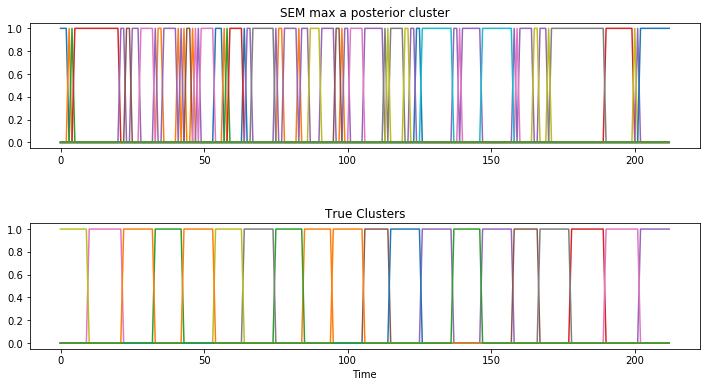

In [12]:
import numpy as np
fig, axes = plt.subplots(2, 1, figsize=(12, 6.0))

max_post = np.zeros(sem.results.post.shape)
for t in range(sem.results.post.shape[0]):
    max_post[t, :] = sem.results.post[t, :] == sem.results.post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')

y_clust = np.zeros((y_train.shape[0], 13))
for ii, y0 in enumerate(y_train):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.6)
plt.show()

It's very important that both the prior and the posterior contribute to the clustering process. For this to happen, the scale of the differences between the different hypothesis in terms of log-likelihood and log-prior not be drastically different. For example, if the difference likelihood between two event models is ~100 and the difference between the same two is ~5 in the log-prior than the likelihood will dominate the clustering. 

This scaling can be controled by the $\beta$ parameter, that is, the likehood noise parameter.

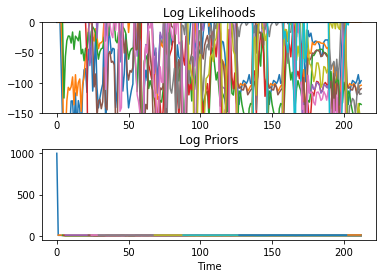

In [13]:
import numpy as np
fig, axes = plt.subplots(2, 1)

axes[0].plot(sem.results.log_like)
axes[0].set_title('Log Likelihoods')
axes[0].set_ylim([-150, 0])

axes[1].plot(sem.results.log_prior)
axes[1].set_title('Log Priors')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()

Let's visualize the event transitions using a lower dimensional representaiton of the state-space. It's pretty clear from this that SEM is using the similarity in the raw feature space to cluster -- it's not using the dynamics of the transition function. This should make sense, given that model doesn't know the tranisiton dynamics ahead of time and must learn them.

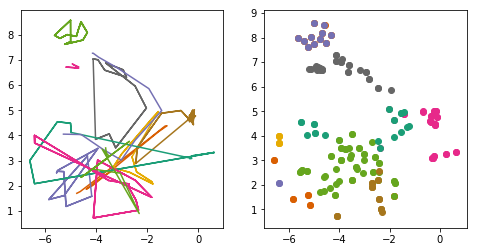

In [14]:
tsne = TSNE(n_components=2, init='random', random_state=0, perplexity=100)
X_embedded = tsne.fit_transform(X_train)
e = motion_data.loc[:, motion_data.columns[-1]].values
cc = sns.color_palette('Dark2', n_colors=len(set(e)))
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for e0 in set(y_train):
    axes[0].plot(X_embedded[y_train == e0, 0], X_embedded[y_train == e0, 1], color=cc[e0])

for e0 in set(y_hat):
    axes[1].scatter(X_embedded[y_hat == e0, 0], X_embedded[y_hat == e0, 1], color=cc[e0])

One of the predictions of previous event models is that prediction errors should be larger at event boundaries than at all other time points. Here, we evaluate the prediction by looking at the prediction error (measured by the absoluted Euclidean distance between the predicted and observed scene vectors) split by whether there was a grand-truth event boundary. 

On the left is the distribution of prediction errors (conditional on the last observed event model, not the MAP event model) for boundary/non-boundary scences. On the right is an R.O.C. curve of a logistic model trained to predict boundaries based on the prediction errors.

Mean PE at Event Boundaries:    1.3398118258433513
Mean PE for all other scences:  0.7871697151187071
t(22.7) = 6.24; p = 2.56171e-06


/anaconda3/envs/sem/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/sem/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


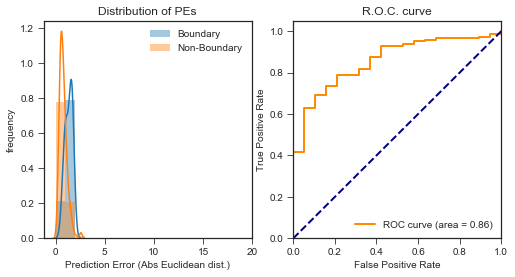

In [15]:
# plot the prediction errors as a function of event boundaries
pe_nonbound = []
pe_bound = []
for ii, y0 in enumerate(y_train[1:], start=1):
    # as an approximation, we consider an event boundary when the event type changes
    if y_train[ii - 1] == y0:
        pe_nonbound.append(sem.results.pe[ii])
    else:
        pe_bound.append(sem.results.pe[ii])

        
# Are PEs larger for event boundaries? t-test with unequal variance/sample size:
print "Mean PE at Event Boundaries:   ", np.mean(pe_bound)
print "Mean PE for all other scences: ", np.mean(pe_nonbound)

from scipy.stats import ttest_ind
t, p = ttest_ind(pe_bound, pe_nonbound, equal_var=False)
n1 = len(pe_bound)
n2 = len(pe_nonbound)
s1 = np.var(pe_bound)
s2 = np.var(pe_nonbound)
df = ((s1/n1 + s2/n2)**2) / ( ((s1/n1)**2)/(n1-1)  + ((s2/n2)**2)/(n2-1) )

print "t(%.1f) = %.2f; p = %g" % (df, t, p)
        
# Calculate the R.O.C curve using the PEs to classify event boundaries

# fit a logistic model, boundary ~ PE
import statsmodels.api as sm
X = np.reshape(np.concatenate([pe_bound, pe_nonbound]), (-1, 1))
X = sm.add_constant(X)
y = np.reshape(np.concatenate([np.zeros(len(pe_bound)),
                    np.ones(len(pe_nonbound))]), (-1, 1))
res = sm.Logit(y, X).fit(disp=0)

# Evaluate logistic model with ROC curve
from sklearn.metrics import roc_curve, auc
y_hat = res.predict(X)
fpr, tpr, thr = roc_curve(y, y_hat)
roc_auc = auc(fpr, tpr)

        
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(1, 2, figsize=(8.2, 4), gridspec_kw=dict(wspace=0.2))  
    
    # plot the distribution of prediction errors
    ax = axes[0]
    sns.distplot(pe_bound, ax=ax, label='Boundary', bins=np.arange(0, 20, 1.0))
    sns.distplot(pe_nonbound, ax=ax, label='Non-Boundary', bins=np.arange(0, 20, 1.0))
    ax.legend()
    ax.set_xlabel('Prediction Error (Abs Euclidean dist.)')
    ax.set_ylabel('frequency')
    ax.set_title('Distribution of PEs')

    # plot the ROC curve
    ax = axes[1]
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('R.O.C. curve')
    plt.legend(loc="lower right")
    plt.show()

Imporatantly, PEs tend to be larger at event boundaries and classification based on these boundaries are well above chance.

### Prediction error across time
True event boundaries shown

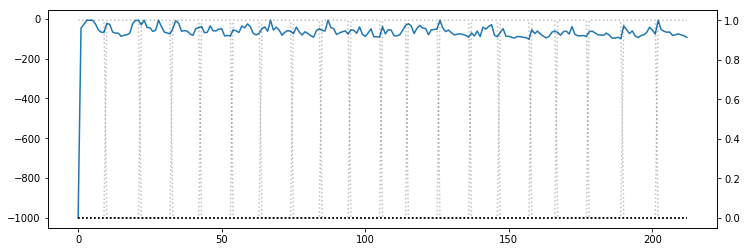

In [16]:
fig, ax1 = plt.subplots(figsize=(12, 4))


ax2 = ax1.twinx()
y_clust = np.zeros((y_train.shape[0], 13))
for ii, y0 in enumerate(y_train):
    y_clust[ii, y0] = 1.0
ax2.plot(y_clust, 'k:', alpha=0.25)


ax1.plot(-sem.results.log_loss)


plt.show()

### Prediction error across time
Estimated event boundaries shown

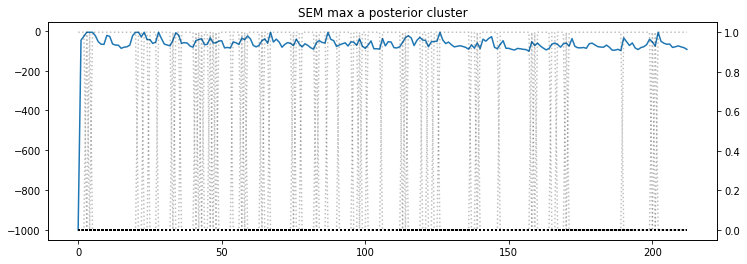

In [17]:
fig, ax1 = plt.subplots(figsize=(12, 4))


ax2 = ax1.twinx()
max_post = np.zeros(sem.results.post.shape)
for t in range(sem.results.post.shape[0]):
    max_post[t, :] = sem.results.post[t, :] == sem.results.post[t, :].max()
ax2.plot(max_post, 'k:', alpha=0.25)
ax2.set_title('SEM max a posterior cluster')

ax1.plot(-sem.results.log_loss)


plt.show()

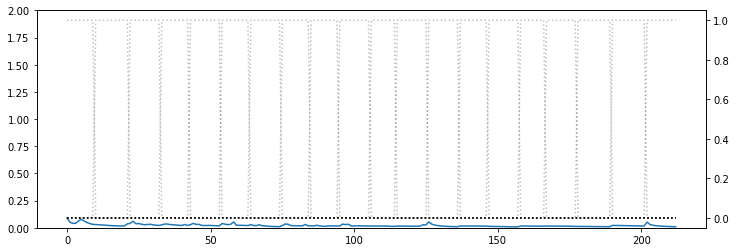

In [18]:
# what would the beta estimate be across time without paying attention to the event boundaries?
n, d = X_train.shape
index = range(n)

all_betas = np.zeros(n)

for e in range(len(set(sem.results.e_hat))):
    Y = X_train[sem.results.e_hat == e, :] - sem.results.y_hat[sem.results.e_hat == e, :]
    Y_idx = np.array(index)[sem.results.e_hat == e]

    n_e = Y.shape[0]
    beta = np.zeros(n_e)
    for ii in range(n_e):
        beta[ii] =  np.std(Y[:ii+1, :].reshape(-1))
        all_betas[Y_idx[ii]] = np.var(Y[:ii+1, :].reshape(-1))

        
fig, ax1 = plt.subplots(figsize=(12, 4))


ax2 = ax1.twinx()
y_clust = np.zeros((y_train.shape[0], 13))
for ii, y0 in enumerate(y_train):
    y_clust[ii, y0] = 1.0
ax2.plot(y_clust, 'k:', alpha=0.25)


ax1.plot(all_betas)
ax1.set_ylim([0, 2])

plt.show()        


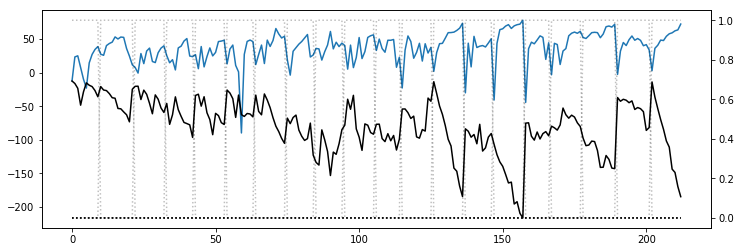

In [19]:
# what is the likelihood based on the implied betas?
from scipy.stats import multivariate_normal as mvnormal

n, d = X_train.shape
likelihood = np.zeros(n)
likelihood_control = np.zeros(n)

Y = X_train - sem.results.y_hat
for ii in range(n):
    likelihood[ii] = mvnormal.logpdf(Y[ii, :], mean=np.zeros(d), cov=np.eye(d) *  all_betas[ii])
    likelihood_control[ii] = mvnormal.logpdf(X_train[ii, :], mean=np.zeros(d), 
                                             cov=np.eye(d) *  all_betas[ii])
    
fig, ax1 = plt.subplots(figsize=(12, 4))


ax2 = ax1.twinx()
y_clust = np.zeros((y_train.shape[0], 13))
for ii, y0 in enumerate(y_train):
    y_clust[ii, y0] = 1.0
ax2.plot(y_clust, 'k:', alpha=0.25)


ax1.plot(likelihood)
ax1.plot(likelihood_control, 'k')

plt.show()    